<a href="https://colab.research.google.com/github/Kennedy87670/Introduction-to-ML-DP/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tranfer learning with Tensorflow part 2: fine-tunning
in the previous notebook, we covered transfer learning features extraction, now its time to learn about a new kind of transfer learning: fine-tuning

In [1]:
# check if we are using a GPU
!nvidia-smi

Fri Jul 22 19:35:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper function

In previous notebooks, we have created a bunch of helper functions, now we could write them all, however this is tedious

So, its a good idea to put functions you will want to use again in a script you can download and import your notebooks (or elsewhere

We have done this for some of the functions we have used previously here 
: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-22 19:35:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-22 19:35:45 (107 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2022-07-22 19:35:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-22 19:35:46 (111 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



**Note** if you are running this notebook in GOOGLE COLAB, WHEN it times out colab will delete "helper_functions.py", so you will have to redownload it if you want access to the helper functions 


# now lets get some data

This time we are goingto see how we can use the pretrained models within tf.keras.applications and apply 
https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2022-07-22 19:35:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 172.253.118.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  89.3MB/s    in 1.8s    

2022-07-22 19:35:50 (89.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

In [6]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode= "categorical",
                                                                            batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode= "categorical",
                                                                            batch_size = BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# see an example of batch
for images, labels in train_data_10_percent.take(1):
  print(images)

tf.Tensor(
[[[[5.59591827e+01 3.93163261e+01 1.33163271e+01]
   [5.34489784e+01 3.61632652e+01 1.18061228e+01]
   [5.48622475e+01 3.55000000e+01 1.35000010e+01]
   ...
   [1.44091782e+02 1.33096939e+02 1.59372574e+02]
   [1.19152679e+02 1.17530312e+02 1.64790710e+02]
   [1.64474274e+02 1.71275269e+02 2.31632401e+02]]

  [[6.28571434e+01 3.71428566e+01 1.40714283e+01]
   [6.29285736e+01 3.62857132e+01 1.51428566e+01]
   [6.54846954e+01 3.79438744e+01 1.68571434e+01]
   ...
   [1.17607307e+02 1.04979813e+02 1.20479897e+02]
   [1.50969727e+02 1.47689209e+02 1.78674042e+02]
   [1.49780624e+02 1.53852051e+02 1.95469376e+02]]

  [[7.05051041e+01 3.75051003e+01 1.85051022e+01]
   [6.95000000e+01 3.60714302e+01 1.70714302e+01]
   [6.87091827e+01 3.37091827e+01 1.47091837e+01]
   ...
   [1.17882622e+02 1.01265320e+02 1.10199020e+02]
   [1.19336807e+02 1.09464417e+02 1.25081841e+02]
   [1.49765228e+02 1.46826447e+02 1.67397858e+02]]

  ...

  [[4.59897690e+01 3.19897671e+01 5.77550411e+00]
   [4


## Model 0: Building a transfer learning feature extraction model using keras functional API
The sequential API is staright-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with out models https://www.tensorflow.org/guide/keras/functional

In [11]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model(so the underlying pre-trained patterns arent updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name = "input_layer")

# 4. If using a model like  ResNET50V2 you will need to normalize inputs ( you dont for eficientNET)
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"shape AFter passing inputs through base model: {x.shape}")

# 6. Average pol the outputs of the base model (aggregate all the most important information, reduce number of computations)
x =tf.keras.layers.GlobalAveragePooling2D(name ="global_average_pooling_layer")(x)
print(f"Shape afer GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
ouputs = tf.keras.layers.Dense(10, activation='softmax', name= 'ouput_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, ouputs)

#9. Compile the model
model_0.compile(loss ="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name = "transfer_learning",
                                                                        experiment_name = "10_percent_feature extraction")]
                                 
                                 )

16719872/16705208 [==============================] - 0s 0us/step
shape AFter passing inputs through base model: (None, 7, 7, 1280)
Shape afer GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature extraction/20220722-193604
Epoch 1/5
24/24 [==============================] - 25s 260ms/step - loss: 1.9067 - accuracy: 0.3920 - val_loss: 1.3698 - val_accuracy: 0.7122
Epoch 2/5
24/24 [==============================] - 5s 194ms/step - loss: 1.1438 - accuracy: 0.7600 - val_loss: 0.9595 - val_accuracy: 0.7780
Epoch 3/5
24/24 [==============================] - 5s 183ms/step - loss: 0.8393 - accuracy: 0.8067 - val_loss: 0.7772 - val_accuracy: 0.7944
Epoch 4/5
24/24 [==============================] - 5s 184ms/step - loss: 0.6827 - accuracy: 0.8413 - val_loss: 0.6963 - val_accuracy: 0.8141
Epoch 5/5
24/24 [==============================] - 4s 148ms/step - loss: 0.5911 - accuracy: 0.8573 - val_loss: 0.6537 - val_accuracy: 0.8141


In [12]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.6105 - accuracy: 0.8356


[0.610517680644989, 0.8356000185012817]

In [13]:
# check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [14]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [15]:
# summary of our model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 ouput_layer (Dense)         (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


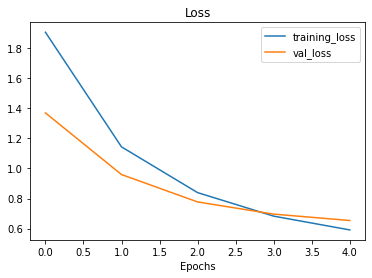

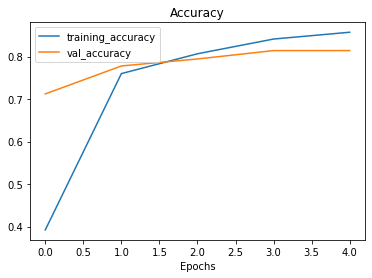

In [16]:
# check out our model training curves
plot_loss_curves(history_10_percent)

## Getting  a feature vector from trained model

lets demonstrate the global Average Pooling 2D layer...

We have a tensor after our model goes through "base_model" of shape (None, 7, 7, 1280)...
But then whenit passes through GlobalAveragePooling2D, it turns into(None, 1280).

lets use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D

In [17]:
#Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooling_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooling_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape pf Global Average Pooled 2D tensor: {global_average_pooling_tensor.shape}")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape pf Global Average Pooled 2D tensor: (1, 3)


In [18]:
# lets replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

** Try to do the same with the above two cells but this time use GlobalMaxPool2D .... and see what happens.

**Note** One of the reasons feature extraction transfer learning is named how it is beacuse what often happens is pretrained model outputs a feature vector (a long tensor of numbers which represents the learned represenatation of the model on a particular sample, in our case, this isthe output of the tf.keras.layers.GlobalAveragePooling2D() LAYER)WHICH CAN THEN BE USED TO EXTRACT PATTERNS OUT FOR OUR OWN SPECIFIC PROBLEM

## Running a seriesof transfer learning experiments

We have seen  the increadle result transfer learning can get with only 10% of the training dat, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. "model_1" - use feature extraction transfer learning with 1% of the traiing data with data augmentation
2. "model_2" use feature extraction transfer learning with 10% of the training with data augmentation
3. "model_3" use fine-tunning transfer learning on 10% of the training data with data augmentation
4. 'model_4' use fine-tunning transfer learning on 100% of the training data with data augmentation

Note: throughout all experiments the same test dataset will be used to evalute our model.... this ensures consistency across evalution metrics

## Getting and preprocessing model_1

In [19]:
# Downlaoa and unzip the data - preprocessed data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2022-07-22 19:37:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 142.250.4.128, 2404:6800:4003:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   240MB/s    in 0.5s    

2022-07-22 19:37:02 (240 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
# create training and test dir
train_dir_1_percent ="10_food_classes_1_percent/train"
test_dir ="10_food_classes_1_percent/test"

In [21]:
# how many images are we working with?
walk_through_dir("10_food_classes_1_percent")


There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There a

In [22]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                          label_mode = "categorical",
                                                                          image_size =IMG_SIZE,
                                                                          batch_size = BATCH_SIZE
                                                                          )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                          label_mode = "categorical",
                                                                          image_size =IMG_SIZE,
                                                                          batch_size = BATCH_SIZE
                                                                          )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Ading data augumentation right into model

To add data augumenatation right into our models, we can use the layers inside:

* tf.keras.layers.experimental.preprocessing()
We can see the benefits of doing this within the Tensorflow data augmentation documentation

Off the top of our heads, after reading the docs, the benefits of using data augmentation inside a model are:
* Preprocessing of image (augmenting them) happens on the GPU (much faster) rather than CPU
* Image data augmentation only happens during training, so we can still export our model and use it elsewhere.

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#create data augumentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
                                       preprocessing.RandomFlip('horizontal'),
                                       preprocessing.RandomRotation(0.2),
                                       preprocessing.RandomZoom(0.2),
                                       preprocessing.RandomHeight(0.2),
                              preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")



### vISUALIZE OUR DATA AUGMENTATION LAYER (and see what happens to our data)

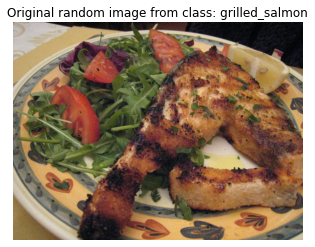

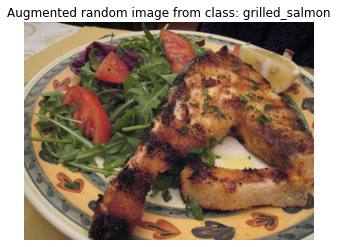

In [24]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: feature extraction transfer learning on 1% of the data with data augmentation

In [25]:
## setup input shape and base model, freezing the base model layers
input_shape= (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create input layers
inputs = layers.Input(shape=input_shape, name="input_layer")

# add in data augmentation Sequential as a layer
x = data_augmentation(inputs)

# Give base_model the iput (after augmentation) and dont train it
x= base_model(x, training=False)

# Pool output feature of the base model
x = layers.GlobalMaxPooling2D(name="global_average_pooling_layer")(x)

# Put a dense laer on as the output
output = layers.Dense(10, activation="softmax", name= "output_layer")(x)

# make a model with inputs and outputs
model_1 = keras.Model(inputs, output)

# compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer =tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch= len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name = "transfer_learning",
                                                                       experiment_name ="1_percent_data_aug")]) 

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220722-193706
Epoch 1/5
3/3 [==============================] - 10s 2s/step - loss: 5.3956 - accuracy: 0.1000 - val_loss: 4.9653 - val_accuracy: 0.1349
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 4.3800 - accuracy: 0.1714 - val_loss: 4.6490 - val_accuracy: 0.1464
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 3.8870 - accuracy: 0.2571 - val_loss: 3.9707 - val_accuracy: 0.1826
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 3.0505 - accuracy: 0.2857 - val_loss: 3.5263 - val_accuracy: 0.1974
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 2.3148 - accuracy: 0.3286 - val_loss: 3.3694 - val_accuracy: 0.2220


In [26]:
#check the summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalMaxPooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [27]:
# evaluate on all the test data
result_1_percent_data_aug = model_1.evaluate(test_data)

79/79 [==============================] - 7s 79ms/step - loss: 3.2275 - accuracy: 0.2348


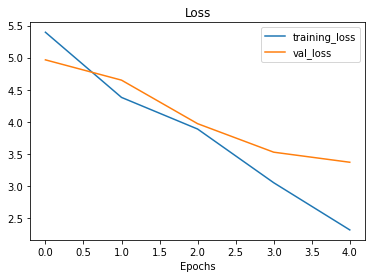

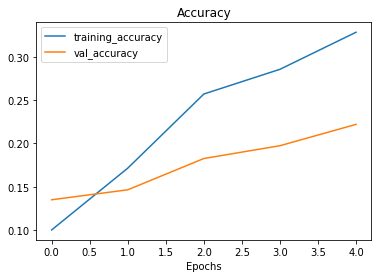

In [28]:
# how does the model with 1% of the data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model2: Feature extraction transfer learning model with 10% of data and data augmentation

In [29]:
train_data_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [30]:
# set the data input
train_data_10_percent= tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                           label_mode="categorical",
                                                                           image_size= IMG_SIZE)
test_data= tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [31]:
# how many images are in our directories?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

 https://keras.io/guides/transfer_learning/

In [32]:
# create model 2 with data augmentation built in
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#create data augumentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
                                       preprocessing.RandomFlip('horizontal'),
                                       preprocessing.RandomRotation(0.2),
                                       preprocessing.RandomZoom(0.2),
                                       preprocessing.RandomHeight(0.2),
                              preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

# setup the input shape to our model 
input_shape = (224,224, 3)

# create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer") 
x = data_augmentation(inputs) # augment our training images (augmentation)
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, this also insures batchnorm layer dont
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 =tf.keras.Model(inputs, outputs)


# compile the model
model_2.compile(loss = "categorical_crossentropy",
                optimizer =tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


24289280/24274472 [==============================] - 1s 0us/step


## Creating a modelCheckpoint callback
The ModelCheckpoint callback intermediately saves our model(the fullmodel or just the weights) during training. Th is is useful so we can come and start where we left off

In [33]:
# Set checkpoint path 
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq ="epoch", # save every epoch
                                                         verbose=1)

In [34]:

# Fit the model 2 passing it checkpoint
initial_epoch = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch= len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name = "transfer_learning",
                                                                       experiment_name ="10_percent_data_aug"),
                                           checkpoint_callback]) 

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220722-193741
Epoch 1/5
3/3 [==============================] - ETA: 0s - loss: 2.3550 - accuracy: 0.1562
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
3/3 [==============================] - 12s 2s/step - loss: 2.3550 - accuracy: 0.1562 - val_loss: 2.1290 - val_accuracy: 0.2434
Epoch 2/5
3/3 [==============================] - ETA: 0s - loss: 2.2270 - accuracy: 0.1667
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
3/3 [==============================] - 4s 2s/step - loss: 2.2270 - accuracy: 0.1667 - val_loss: 2.0113 - val_accuracy: 0.3388
Epoch 3/5
3/3 [==============================] - ETA: 0s - loss: 2.0530 - accuracy: 0.3021
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
3/3 [==============================] - 4s 2s/step - loss: 2.0530 - accuracy: 0.3021 - val_loss: 1.9124 - val_accuracy: 0.4095
Epoch 4/5
3/3 [=========

In [35]:
# what were model_0 results
model_0.evaluate(test_data)

79/79 [==============================] - 9s 99ms/step - loss: 0.6105 - accuracy: 0.8356


[0.6105177402496338, 0.8356000185012817]

In [38]:
# check model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 7s 80ms/step - loss: 1.6998 - accuracy: 0.5404


[1.6997687816619873, 0.5404000282287598]

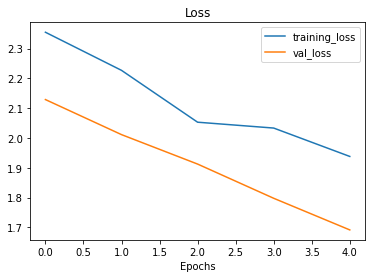

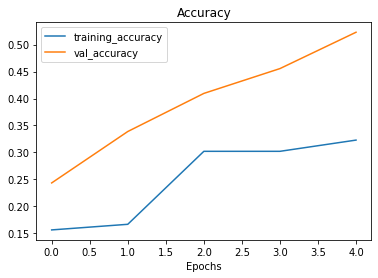

In [40]:
#plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint


In [41]:
# load in saved model wightsa and evaluate model
model_2.load_weights(checkpoint_path)

In [42]:
#Evalaute model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 79ms/step - loss: 1.6998 - accuracy: 0.5404


In [43]:
# if the results from our previously evaluated model_2 match the loaded weights, everything has worked!!
results_10_percent_data_aug == loaded_weights_model_results

True

In [46]:
# check to see if loaded model result are very close to our previous non-loaed model results

import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [48]:
# check the difference between two results 
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results) ) 

[0. 0.]
